In [1]:
# Célula 0 – Fixar semente para reprodutibilidade
# ------------------------------------------------
import os, random, numpy as np

SEED = 42                # use qualquer inteiro; 42 é “convencional”
random.seed(SEED)        # Python puro
np.random.seed(SEED)     # NumPy
os.environ["PYTHONHASHSEED"] = str(SEED)

# Se em algum momento usar frameworks que aceitam seed,
# passe o mesmo número, ex.:
# model = RandomForestClassifier(random_state=SEED)


In [2]:
# Célula 1
# ---------------------------------------------------------------
# Objetivo: carregar as bibliotecas essenciais e ler o arquivo CSV
# com os dados de solo/clima + rótulo da cultura.

import pandas as pd          # manipulação de dados em tabelas
import seaborn as sns        # (usaremos só mais adiante para gráficos)
import matplotlib.pyplot as plt  # idem, para possíveis visualizações

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Modelos que usaremos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Leia o arquivo CSV (ajuste o nome se estiver diferente)
df = pd.read_csv("Atividade_Cap_14_produtos_agricolas.csv")

# Exibe as 5 primeiras linhas para confirmar leitura
df.head()


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [3]:
# Célula 2
# ------------------------------------------------------------------
# Objetivo: transformar o DataFrame bruto em conjuntos de treino e
# teste prontos para alimentar KNN, Regressão Logística, Árvore de
# Decisão, Random Forest e SVM.

# 1) Separa features (X) e alvo (y)
X = df.drop('label', axis=1)   # todas as colunas numéricas
y = df['label']                # nome da cultura

# 2) Codifica os rótulos textuais em inteiros
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)     # ex.: "rice" → 17

# 3) Divide em treino (80 %) e teste (20 %),
#    mantendo a proporção de cada cultura (stratify)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.20, random_state=42, stratify=y_enc
)

# 4) Normaliza todas as variáveis numéricas para o intervalo [0, 1]
#    — obrigatório para KNN, SVM e Reg. Log.; não atrapalha as árvores.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# 5) Checagem rápida
print("Shape treino:", X_train_s.shape)
print("Shape teste :", X_test_s.shape)
print("Classes alvo:", le.classes_)


Shape treino: (1760, 7)
Shape teste : (440, 7)
Classes alvo: ['apple' 'banana' 'blackgram' 'chickpea' 'coconut' 'coffee' 'cotton'
 'grapes' 'jute' 'kidneybeans' 'lentil' 'maize' 'mango' 'mothbeans'
 'mungbean' 'muskmelon' 'orange' 'papaya' 'pigeonpeas' 'pomegranate'
 'rice' 'watermelon']


In [4]:
# Célula 3
# ------------------------------------------------------------------
# Objetivo: treinar e avaliar o classificador KNN, que prevê a cultura
# de uma amostra comparando-a com as k amostras mais próximas no espaço
# das características.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1) Instanciar o modelo
knn = KNeighborsClassifier(n_neighbors=7)  # k = 7 é um valor comum de partida

# 2) Treinar com os dados escalonados
knn.fit(X_train_s, y_train)

# 3) Prever no conjunto de teste
y_pred_knn = knn.predict(X_test_s)

# 4) Avaliar
acc_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN accuracy: {acc_knn:.3f}\n")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))


KNN accuracy: 0.984

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       0.95      1.00      0.98        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       0.95      1.00      0.98        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       0.95      1.00      0.98        20
      lentil       0.91      1.00      0.95        20
       maize       1.00      0.95      0.97        20
       mango       0.95      1.00      0.98        20
   mothbeans       1.00      0.85      0.92        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange       1.00      1.00      1.00        20
      

In [5]:
# Célula 4
# ------------------------------------------------------------------
# Objetivo: treinar e avaliar a Regressão Logística (versão multiclasse),
# que aprende fronteiras lineares entre as culturas no espaço das features.

from sklearn.linear_model import LogisticRegression

# 1) Instanciar o modelo
#    - max_iter: garante convergência
#    - solver 'lbfgs' lida bem com muitos rótulos
lr = LogisticRegression(max_iter=300, solver='lbfgs')

# 2) Treinar
lr.fit(X_train_s, y_train)

# 3) Prever
y_pred_lr = lr.predict(X_test_s)

# 4) Avaliar
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression accuracy: {acc_lr:.3f}\n")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))


Logistic Regression accuracy: 0.941

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       0.95      0.95      0.95        20
    chickpea       1.00      1.00      1.00        20
     coconut       0.95      1.00      0.98        20
      coffee       1.00      1.00      1.00        20
      cotton       0.87      1.00      0.93        20
      grapes       1.00      1.00      1.00        20
        jute       1.00      0.80      0.89        20
 kidneybeans       0.91      1.00      0.95        20
      lentil       0.89      0.85      0.87        20
       maize       1.00      0.85      0.92        20
       mango       0.83      1.00      0.91        20
   mothbeans       0.88      0.75      0.81        20
    mungbean       0.91      1.00      0.95        20
   muskmelon       0.91      1.00      0.95        20
      orange       1.00      0.90      0.95 

In [6]:
# Célula 5
# ------------------------------------------------------------------
# Objetivo: treinar e avaliar uma Decision Tree (Árvore de Decisão),
# que cria regras tipo “se pH < 6.5 e K > 40 então cultura = X”.

from sklearn.tree import DecisionTreeClassifier

# 1) Instanciar o modelo
#    - random_state fixa a aleatoriedade p/ reprodutibilidade
#    - max_depth=None deixa a árvore crescer livremente (podemos podar depois)
dt = DecisionTreeClassifier(random_state=42)

# 2) Treinar
dt.fit(X_train_s, y_train)

# 3) Prever
y_pred_dt = dt.predict(X_test_s)

# 4) Avaliar
acc_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree accuracy: {acc_dt:.3f}\n")
print(classification_report(y_test, y_pred_dt, target_names=le.classes_))


Decision Tree accuracy: 0.980

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.80      0.89        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      0.95      0.95        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.86      0.90      0.88        20
       maize       0.95      1.00      0.98        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.86      0.95      0.90        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange       1.00      1.00      1.00       

In [7]:
# Célula 6
# ------------------------------------------------------------------
# Objetivo: treinar e avaliar uma Random Forest, que combina
# múltiplas árvores de decisão construídas em amostras aleatórias
# do conjunto de treino para reduzir overfitting e aumentar robustez.

from sklearn.ensemble import RandomForestClassifier

# 1) Instanciar o modelo
#    - n_estimators: número de árvores (200 é um bom ponto de partida)
#    - random_state: garante resultados reprodutíveis
rf = RandomForestClassifier(n_estimators=200, random_state=42)

# 2) Treinar
rf.fit(X_train_s, y_train)

# 3) Prever
y_pred_rf = rf.predict(X_test_s)

# 4) Avaliar
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest accuracy: {acc_rf:.3f}\n")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))


Random Forest accuracy: 0.995

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.95      0.97        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        20
       maize       0.95      1.00      0.98        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange       1.00      1.00      1.00       

In [8]:
# Célula 7
# ------------------------------------------------------------------
# Objetivo: treinar e avaliar uma SVM com kernel RBF (função gaussiana).
# Ela procura um hiperplano que maximize a margem entre classes;
# o kernel RBF permite fronteiras não lineares.

from sklearn.svm import SVC

# 1) Instanciar o modelo
#    - C controla a penalização a erros (maior C = menos margem, mais overfitting)
#    - gamma controla o "raio de influência" de cada ponto
svm = SVC(kernel="rbf", C=10, gamma="scale")   # 'scale' é 1/(n_features * var)

# 2) Treinar (usa os dados já escalonados)
svm.fit(X_train_s, y_train)

# 3) Prever
y_pred_svm = svm.predict(X_test_s)

# 4) Avaliar
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM (RBF) accuracy: {acc_svm:.3f}\n")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))


SVM (RBF) accuracy: 0.991

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       0.95      1.00      0.98        20
      grapes       1.00      1.00      1.00        20
        jute       0.91      1.00      0.95        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.95      1.00      0.98        20
       maize       1.00      0.95      0.97        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      0.95      0.97        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange       1.00      1.00      1.00        20


RandomForest    0.995455
SVM_RBF         0.990909
KNN             0.984091
DecisionTree    0.979545
LogReg          0.940909
dtype: float64


Melhor modelo: RandomForest  |  accuracy = 0.995


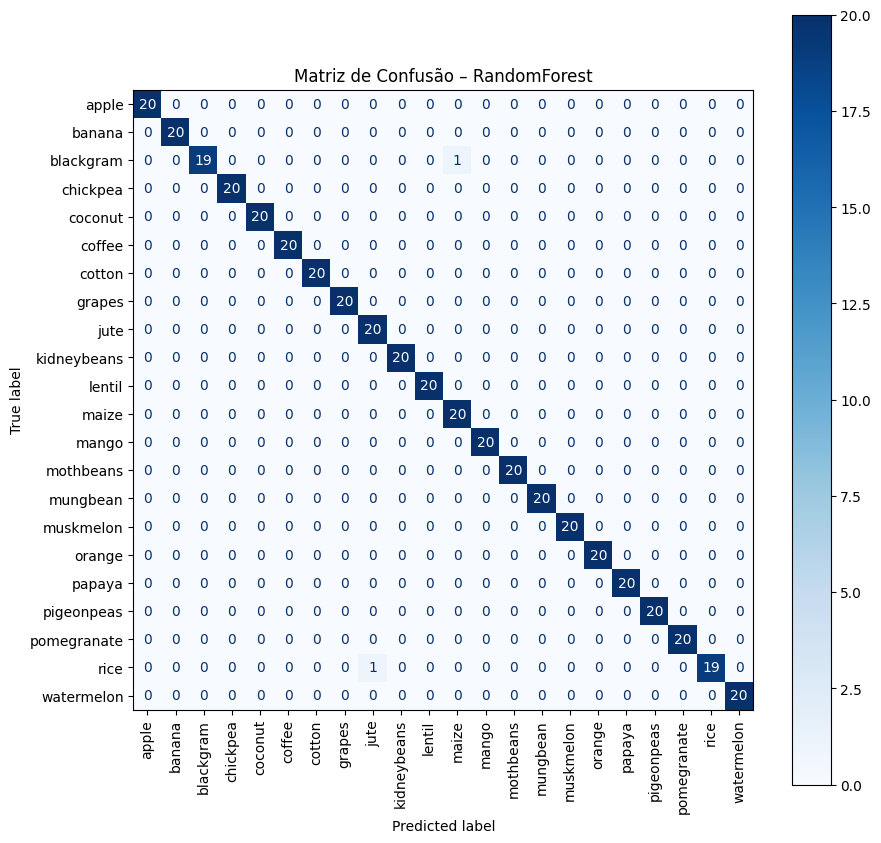

In [9]:
# Célula 8
# ------------------------------------------------------------------
# Objetivo:
# 1) Criar uma tabela comparativa de accuracy dos 5 modelos.
# 2) Identificar o vencedor.
# 3) Exibir a matriz de confusão do modelo campeão para entender
#    onde ele erra ou acerta em cada cultura.

import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1) Tabela de accuracies
accuracies = {
    "KNN": acc_knn,
    "LogReg": acc_lr,
    "DecisionTree": acc_dt,
    "RandomForest": acc_rf,
    "SVM_RBF": acc_svm
}
acc_series = pd.Series(accuracies).sort_values(ascending=False)
display(acc_series)

# 2) Seleciona o melhor modelo automaticamente
best_name = acc_series.idxmax()
best_acc  = acc_series.max()

model_dict = {
    "KNN": knn,
    "LogReg": lr,
    "DecisionTree": dt,
    "RandomForest": rf,
    "SVM_RBF": svm
}
best_model = model_dict[best_name]

print(f"\nMelhor modelo: {best_name}  |  accuracy = {best_acc:.3f}")

# 3) Matriz de confusão do melhor modelo
y_best = best_model.predict(X_test_s)
cm = confusion_matrix(y_test, y_best)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues')
plt.title(f"Matriz de Confusão – {best_name}")
plt.show()
